# Exercise 4: Saliency Maps

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy.stats as scp
from scipy.ndimage import gaussian_filter

%matplotlib inline

# 1. Saliency Maps from Local Standard Deviation

## 1. 

(99, 150, 3)

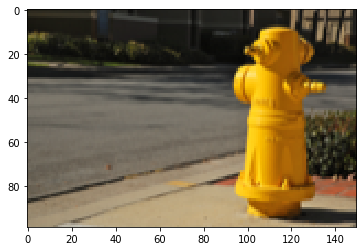

In [2]:
img = imread('salience_02.png')
plt.imshow(img)
img.shape

In [3]:
def show_components(img):
    fig, axs = plt.subplots(1, 4, figsize = (15, 10))

    axs[0].imshow(img)
    for i, ax in enumerate(axs.ravel()[1:]):
        ax.imshow(img[:, :, i], cmap = 'gray')

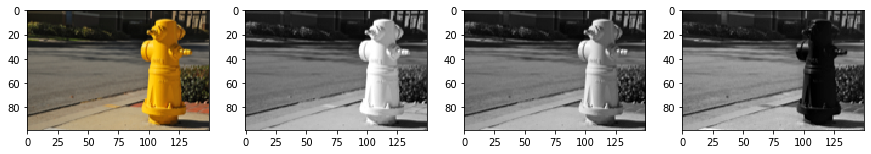

In [4]:
show_components(img)

In [5]:
red_comp = img[:, :, 0].flatten()
green_comp = img[:, :, 1].flatten()
blue_comp = img[:, :, 2].flatten()
all_comp = np.vstack((red_comp, green_comp, blue_comp))
np.corrcoef(all_comp)

array([[1.        , 0.94994194, 0.36971798],
       [0.94994194, 1.        , 0.59863754],
       [0.36971798, 0.59863754, 1.        ]])

**Is there anything striking in the correlations?**

There is very high correlation betweeen all colors, especially red and green.

**Why it is not suprising given the way natural images arise?**

Natural images have a lot of correlation between pixel values.


## 2. 

(99, 150, 3)


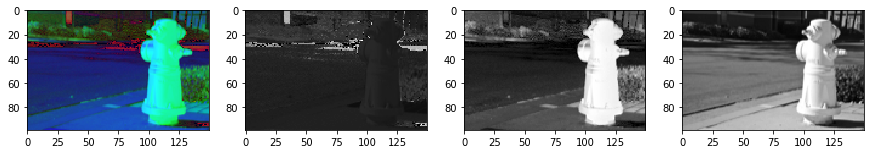

In [6]:
img_hsv = mlp.colors.rgb_to_hsv(img)
print(img_hsv.shape)
show_components(img_hsv)

In [7]:
hue_comp = img_hsv[:, :, 0].flatten()
saturation_comp = img_hsv[:, :, 1].flatten()
val_comp = img_hsv[:, :, 2].flatten()
all_comp = np.vstack((hue_comp, saturation_comp, val_comp))
np.corrcoef(all_comp)

array([[ 1.        , -0.22358772, -0.36745728],
       [-0.22358772,  1.        ,  0.55871773],
       [-0.36745728,  0.55871773,  1.        ]])

**Why is there less correlation?**

In RGB the color channels are correlated because in order to mix a certain color, the same combination needs to be used.
HSV seperates the image intensity from the color information, thus having different feature dimensions.

## 3.  & 4. & 5.

In [8]:
def x_in_border(img, x, x_half):
    return np.all(x + x_half + 1 < img.shape[1] and x - x_half > 0)

def y_in_border(img, y, y_half):
    return np.all(y + y_half + 1 < img.shape[0] and y - y_half > 0)

In [9]:
def extract_patch(img, l_x, l_y, x, y):
    """Extract patches from the img from position x, y with length l_x and l_y, respectively.
    Returns None if parts of the patch are not within the borders."""
    
    x_half = l_x//2
    y_half = l_y//2
    
    if not x_in_border(img, x, x_half+1):
        return -17
#         return None
        
    if not y_in_border(img, y, y_half+1):
        return -17
#         return None
    
    # Cave. Assuming x should be the horizontal direction and y the vertical,
    # the accesses has to be img[y, x].
    return img[y-y_half:y+y_half+1, x-x_half:x+x_half+1]

In [10]:
hue_comp = hue_comp.reshape(img_hsv.shape[0], img_hsv.shape[1])
saturation_comp = saturation_comp.reshape(img_hsv.shape[0], img_hsv.shape[1])
val_comp = val_comp.reshape(img_hsv.shape[0], img_hsv.shape[1])
val_comp.shape

(99, 150)

In [11]:
def calc_sal_map(img_component, patch_width, use_circ_std=False):
    patch_width_sided = patch_width //2
    y_half = patch_width_sided
    x_half = patch_width_sided
    
    start_x = patch_width_sided
    stop_x = img.shape[1]-patch_width_sided
    
    start_y = patch_width_sided
    stop_y = img.shape[0]-patch_width_sided
    
    x = np.linspace(start_x, stop_x, stop_x - start_x, dtype = int)
    y = np.linspace(start_y, stop_y, stop_y - start_y, dtype = int)
    xv, yv = np.meshgrid(x, y)
    
    sal_map = []
    for x, y in zip(xv, yv):
        for xx, yy in zip(x, y):
            patch = img_component[yy-y_half:yy+y_half+1, xx-x_half:xx+x_half+1]
            if use_circ_std:
                sal_map.append(scp.circstd(patch, high = 1))
            else:
                sal_map.append(np.std(patch))
    
    return np.array(sal_map).reshape(stop_y - start_y, stop_x - start_x)

In [12]:
patch_size = 15
sal_map_hue = calc_sal_map(hue_comp, patch_size, True)
sal_map_saturation = calc_sal_map(saturation_comp, patch_size)
sal_map_val = calc_sal_map(val_comp, patch_size)

In [13]:
sal_map = sal_map_hue + sal_map_saturation + sal_map_val
sal_map.shape

(85, 136)

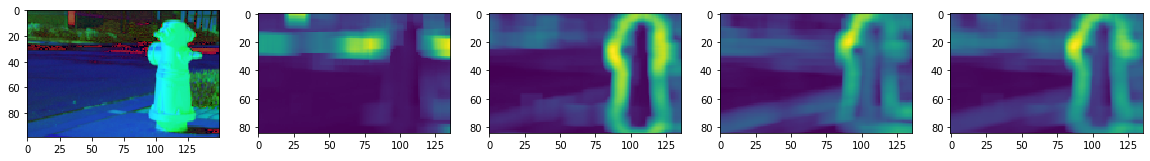

In [14]:
fig, axs = plt.subplots(1, 5, figsize = (20, 10))

axs[0].imshow(img_hsv)
axs[1].imshow(sal_map_hue)
axs[2].imshow(sal_map_saturation)
axs[3].imshow(sal_map_val)
axs[4].imshow(sal_map);

**How is each of the images related to the visual properties of the image?**

- Hue: The color is represnted by the angular dimension. Different Colors are represented by different values along the circle regardless of the other features. The blue property in the image actually relates to the values of the yellow.

- Saturation: As there is an edge representing high contrast in terms of saturation (see property above) from bright yellow to grey (huge brightness change), which shows up as higher values in the saturation salience map.

- Value: In line with the reasoning for the saturation, the highest contrast between the lightness of the image varies most strongly at the border of the hydrant.

## 6. 

In [15]:
sigmas = [2, 5, 10]
modes = ['reflect', 'nearest', 'constant', 'mirror', 'wrap']

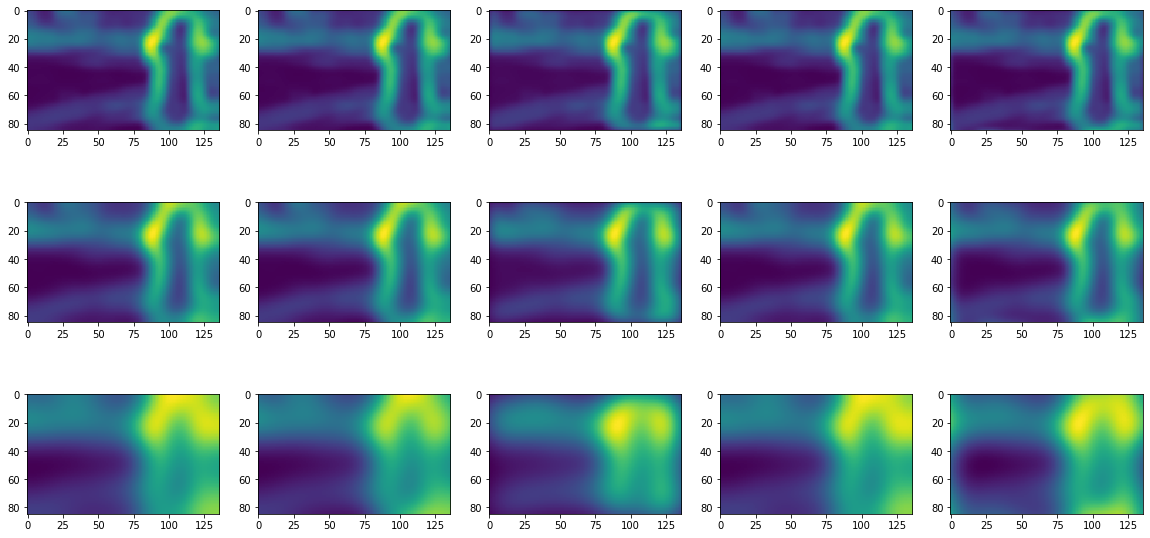

In [16]:
fig, axs = plt.subplots(len(sigmas), len(modes), figsize = (20, 10))
for i, s in enumerate(sigmas):
    for j, m in enumerate(modes):
        filtered_map = gaussian_filter(sal_map, sigma = s, mode = m)
        axs[i][j].imshow(filtered_map)

The best saliency map in our opinion is obtained for constant padding and sigma = 10. It shows that the attention is drawn toward the whole object in the foreground (the hydrant), not only to its borders.

## 7.

In [32]:
filtered_map = gaussian_filter(sal_map, sigma = 10, mode = 'constant')

(85, 136)
(85, 136, 3)


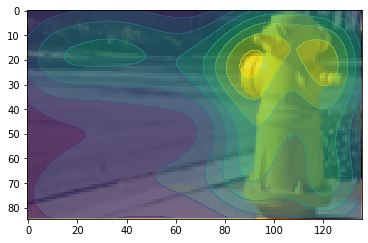

In [35]:
print(sal_map.shape)
patch_width_sided = 7
start_x = patch_width_sided
stop_x = img.shape[0]-patch_width_sided
    
start_y = patch_width_sided
stop_y = img.shape[1]-patch_width_sided

img_section = img[start_x:stop_x, start_y:stop_y, :]
print(img_section.shape)

plt.imshow(img_section)
plt.contourf(filtered_map, alpha = 0.6);

## 8.

(53, 0)


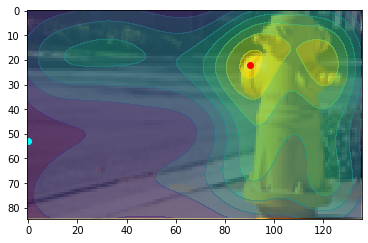

In [50]:
max_idx = np.argmax(filtered_map)
max_coord = np.unravel_index(max_idx, (filtered_map.shape[0], filtered_map.shape[1]))

min_idx = np.argmin(filtered_map)
min_coord = np.unravel_index(min_idx, (filtered_map.shape[0], filtered_map.shape[1]))
print(min_coord)

plt.imshow(img_section)


plt.plot(max_coord[1], max_coord[0], marker = 'o', color = 'red')
# Acqua is the best kind of blue for this map.
plt.plot(min_coord[1], min_coord[0], marker = 'o', color = 'aqua')

plt.contourf(filtered_map, alpha = 0.6);

**How do you interpret the completed image?**